In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.9 MB/s eta 0:00:00


In [ ]:
# https://212digital.medium.com/harnessing-gpt-2-a-deep-dive-into-inference-2e17511ab09c

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchtext
import json
import random

In [ ]:
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

In [39]:
tokenizergpt2xl = GPT2Tokenizer.from_pretrained("gpt2-xl")
modelgpt2xl = GPT2LMHeadModel.from_pretrained("gpt2-xl")

# Data

In [ ]:
# data: https://www.kaggle.com/datasets/jacksoncrow/wikipedia-multimodal-dataset-of-good-articles

In [ ]:
with open('text.json', 'r') as file:
  file_content = file.read()
  file_content_str = json.loads(file_content)
  file_content_dict = json.loads(file_content_str)
  print(file_content_dict)
  print(type(file_content_dict))

{'title': 'Aloe vera', 'id': 1548277, 'url': 'https://en.wikipedia.org/wiki/Aloe_vera', 'text': ' \n\nthumb|Aloe vera - Muséum de Toulouse (MHNT)\n\nAloe vera ( or ) is a succulent plant species of the genus Aloe. An evergreen perennial, it originates from the Arabian Peninsula, but grows wild in tropical, semi-tropical, and arid climates around the world. It is cultivated for agricultural and medicinal uses. The species is also used for decorative purposes and grows successfully indoors as a potted plant.\n\nIt is found in many consumer products including beverages, skin lotion, cosmetics, or ointments for minor burns and sunburns.  There is little clinical evidence for the effectiveness or safety of Aloe vera extract as a cosmetic or medicine.\n\nDescription\nAloe vera is a stemless or very short-stemmed plant growing to 60–100\xa0cm (24–39\xa0in) tall, spreading by offsets. The leaves are thick and fleshy, green to grey-green, with some varieties showing white flecks on their upper 

In [ ]:
def tokenize_data(data_dict, tokenizer):
  input_ids = 0
  attention_mask = 0
  for i in range(0, len(file_content_dict['text']), 200):
    enc = tokenizer(file_content_dict['text'][i:i+200], return_tensors="pt")
    if i == 0:
      input_ids = enc["input_ids"]
      attention_mask = enc["attention_mask"]
    else:
      input_ids = torch.cat((input_ids, enc["input_ids"]), 1)
      attention_mask = torch.cat((attention_mask, enc["attention_mask"]), 1)
  return input_ids, attention_mask

In [ ]:
input_ids, attention_mask = tokenize_data(file_content_dict, tokenizergpt2)

In [41]:
print("Number of tokens: ", input_ids.size())

Number of tokens:  torch.Size([1, 2559])


In [42]:
print(''.join([tokenizergpt2.decode(token) for token in input_ids]))

 

thumb|Aloe vera - Muséum de Toulouse (MHNT)

Aloe vera ( or ) is a succulent plant species of the genus Aloe. An evergreen perennial, it originates from the Arabian Peninsula, but grows wild in tropical, semi-tropical, and arid climates around the world. It is cultivated for agricultural and medicinal uses. The species is also used for decorative purposes and grows successfully indoors as a potted plant.

It is found in many consumer products including beverages, skin lotion, cosmetics, or ointments for minor burns and sunburns.  There is little clinical evidence for the effectiveness or safety of Aloe vera extract as a cosmetic or medicine.

Description
Aloe vera is a stemless or very short-stemmed plant growing to 60–100 cm (24–39 in) tall, spreading by offsets. The leaves are thick and fleshy, green to grey-green, with some varieties showing white flecks on their upper and lower stem surfaces.Yates A. (2002) Yates Garden Guide. Harper Collins Australia The margin of the leaf is s

In [43]:
input_ids_xl, attention_mask_xl = tokenize_data(file_content_dict, tokenizergpt2xl)

# Accuracy measurements

In [ ]:
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]

In [44]:
# function to calculate accuracies at various context lengths
# output:
# the key is the context length and the value is a list of lists.
# the first element in the inner list is the start index of that the context
# the second element is the accuracy of the next token
def calculate_accuracies(model, output_filename, context_lengths, input_ids, attention_mask, num_examples, sample=False, temperature=None, top_p=None):
  output_dict = {}
  for i in context_lengths:
    output_dict[i] = []
    #select random start indices that are between 0 and last_index(length - 1) - i
    start_indices = random.sample(range(0, input_ids.size()[1] - i), num_examples)
    for j in start_indices:
      # access the input at random start index to random start index + i
      curr_input_ids = input_ids[:, j:j+i]
      curr_attention_mask = attention_mask[:, j:j+i]
      # predict next word for that context
      with torch.inference_mode():
        if sample:
          pred = model.generate(curr_input_ids, max_new_tokens=1, attention_mask=curr_attention_mask, pad_token_id=50256, do_sample=sample, temperature=temperature, top_p=top_p)
        else:
          pred = model.generate(curr_input_ids, max_new_tokens=1, attention_mask=curr_attention_mask, pad_token_id=50256, do_sample=sample)
      pred_new_token = pred[0, -1]
      correct_next_token = input_ids[0, j+i]
      acc = 1 if pred_new_token == correct_next_token else 0
      # append result to dictionary
      output_dict[i].append([j, acc])
    # for each i, write to a json file
    with open(output_filename, "r") as file:
      current = json.load(file)
    current[i] = output_dict[i]
    with open(output_filename, "w") as file:
      json.dump(current, file)
    print(output_dict[i])
  return output_dict

In [47]:
def plot_avg_accuracies(accuracy_dict, mode):
  x = []
  y = []
  for key, value in accuracy_dict.items():
    x.append(key)
    inter = []
    for v in value:
      inter.append(v[1])
    y.append(sum(inter)/len(inter))

  plt.figure(figsize=(7, 5))
  plt.plot(x, y)
  plt.title("Average accuracy as a function of context length: " + mode)
  plt.xlabel("Length of context")
  plt.ylabel("Average accuracy")

### Greedy - 10 examples

In [ ]:
output_greedy = calculate_accuracies(model=modelgpt2, output_filename="accuracies_gpt2_greedy.json",
                                     context_lengths=context_lengths, input_ids=input_ids, attention_mask=attention_mask, num_examples=10, sample=False, temperature=None, top_p=None)

Text(0, 0.5, 'Average accuracy')

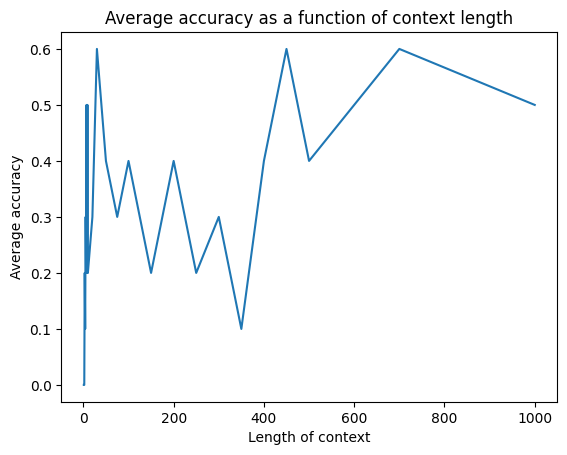

In [ ]:
plot_avg_accuracies(output_greedy, "")

### Greedy - 50 examples

In [15]:
output_greedy_50 = calculate_accuracies(model=modelgpt2, output_filename="accuracies_gpt2_greedy_50.json",
                                     context_lengths=context_lengths, input_ids=input_ids, attention_mask=attention_mask, num_examples=50, sample=False, temperature=None, top_p=None)

[[2310, 0], [602, 1], [1577, 0], [2104, 0], [213, 0], [852, 0], [1826, 0], [2160, 0], [486, 0], [840, 0], [1149, 0], [2085, 0], [1555, 0], [1162, 0], [359, 0], [1504, 0], [1123, 0], [1423, 0], [116, 0], [2180, 0], [1473, 0], [13, 0], [1151, 0], [285, 0], [669, 0], [75, 1], [1960, 0], [139, 0], [1574, 1], [2452, 0], [2205, 0], [70, 0], [2302, 0], [1644, 1], [557, 1], [134, 0], [52, 0], [2290, 0], [1213, 0], [1117, 0], [693, 0], [1043, 0], [98, 0], [667, 0], [1056, 0], [2023, 0], [1413, 0], [204, 0], [1841, 0], [2401, 0]]
[[707, 0], [519, 0], [1310, 0], [765, 1], [1620, 1], [1692, 0], [908, 0], [2179, 0], [1849, 0], [792, 0], [901, 0], [1560, 0], [1567, 0], [416, 0], [1261, 0], [1228, 0], [1485, 0], [244, 0], [730, 0], [2357, 0], [2068, 0], [2421, 0], [1377, 0], [1011, 0], [859, 0], [1125, 0], [2391, 0], [1322, 0], [1217, 0], [1382, 0], [388, 0], [466, 0], [801, 0], [1959, 1], [850, 0], [1180, 0], [149, 0], [1638, 0], [170, 0], [695, 0], [1759, 0], [1594, 0], [815, 0], [906, 0], [1337, 0

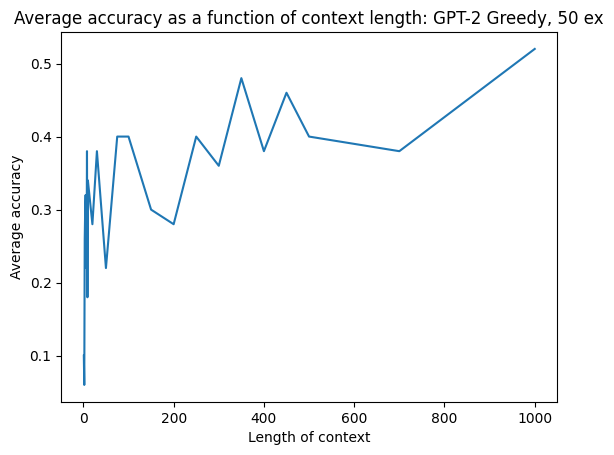

In [16]:
plot_avg_accuracies(output_greedy_50, "GPT-2 Greedy, 50 ex")

### Sampling (temperature=0.5, top-p=0.7)

In [ ]:
# https://www.linkedin.com/pulse/creatively-deterministic-what-temperature-topp-ai-kevin-tupper/

In [17]:
output_sampling1_50 = calculate_accuracies(model=modelgpt2, output_filename="accuracies_gpt2_temp0-5_topp0-7_50samples.json",
                                     context_lengths=context_lengths, input_ids=input_ids, attention_mask=attention_mask, num_examples=50, sample=True, temperature=0.5, top_p=0.7)

[[671, 1], [2069, 0], [2548, 0], [2193, 0], [198, 0], [1602, 1], [1731, 0], [1109, 0], [563, 0], [15, 0], [853, 0], [897, 0], [1942, 0], [2519, 0], [1510, 0], [812, 0], [1743, 0], [53, 0], [1975, 0], [1674, 0], [2071, 0], [566, 0], [264, 0], [1713, 0], [1909, 0], [1394, 0], [1181, 0], [1783, 0], [560, 0], [2320, 0], [1698, 0], [1401, 0], [1085, 0], [138, 0], [1506, 0], [2260, 1], [975, 0], [1855, 0], [1195, 0], [237, 0], [696, 0], [146, 0], [625, 0], [1159, 0], [2063, 0], [409, 0], [1445, 0], [2245, 0], [2208, 0], [124, 0]]
[[1359, 0], [2419, 1], [968, 0], [379, 0], [488, 0], [2307, 0], [356, 1], [606, 0], [2516, 0], [2064, 0], [1043, 0], [2496, 0], [771, 0], [33, 0], [35, 0], [1072, 0], [1754, 0], [2089, 0], [2119, 0], [435, 0], [1826, 1], [1972, 0], [731, 0], [1486, 0], [2225, 0], [1749, 0], [775, 0], [1630, 1], [1621, 0], [2021, 0], [1876, 0], [1654, 0], [1527, 0], [724, 0], [452, 0], [1378, 0], [1171, 0], [2309, 1], [2124, 0], [106, 0], [1934, 0], [131, 0], [243, 0], [781, 0], [164

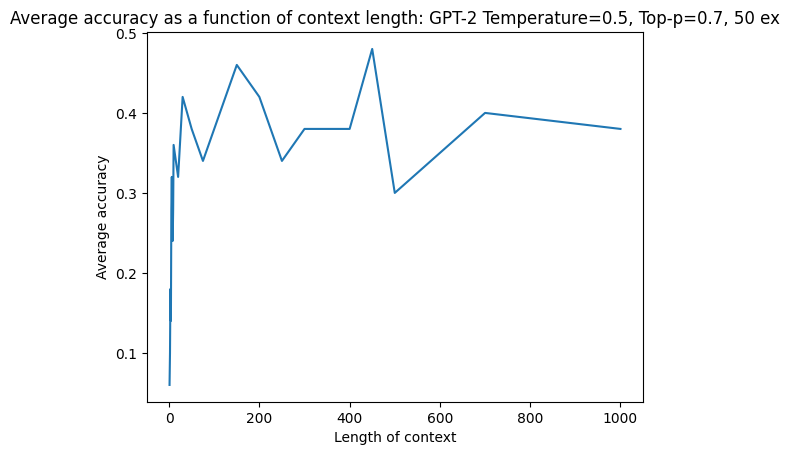

In [18]:
plot_avg_accuracies(output_sampling1_50, "GPT-2 Temperature=0.5, Top-p=0.7, 50 ex")

### Sampling (temperature=1, top-p=0.7)

In [26]:
output_sampling2_50 = calculate_accuracies(model=modelgpt2, output_filename="accuracies_gpt2_temp1_topp0-7_50samples.json",
                                     context_lengths=context_lengths, input_ids=input_ids, attention_mask=attention_mask, num_examples=50, sample=True, temperature=1, top_p=0.7)

[[1363, 0], [128, 0], [260, 0], [631, 0], [2452, 0], [1201, 0], [526, 0], [1079, 0], [1981, 0], [2514, 0], [1538, 0], [1617, 0], [823, 0], [989, 0], [109, 0], [1839, 0], [1208, 0], [657, 0], [456, 0], [1044, 0], [2420, 0], [976, 0], [1212, 0], [2364, 0], [1864, 0], [534, 0], [384, 0], [952, 0], [2215, 0], [2437, 0], [430, 0], [2071, 0], [1911, 0], [238, 0], [1960, 0], [2125, 0], [2281, 0], [342, 0], [380, 0], [1937, 0], [2407, 0], [2259, 0], [2061, 0], [229, 0], [967, 0], [463, 0], [1502, 0], [1410, 0], [1138, 0], [2381, 1]]
[[1047, 0], [1976, 0], [2302, 0], [1542, 0], [1135, 0], [1363, 1], [1977, 0], [924, 0], [2408, 0], [2165, 0], [298, 0], [738, 0], [2306, 0], [204, 1], [2155, 0], [1014, 0], [715, 0], [2418, 0], [2407, 0], [723, 0], [1534, 0], [1676, 0], [2224, 0], [1972, 0], [1076, 1], [191, 1], [344, 1], [1447, 0], [996, 0], [1991, 0], [1586, 0], [188, 0], [1951, 0], [586, 1], [939, 0], [1438, 0], [1521, 0], [757, 0], [2531, 0], [1780, 0], [2311, 0], [1195, 0], [929, 0], [422, 0],

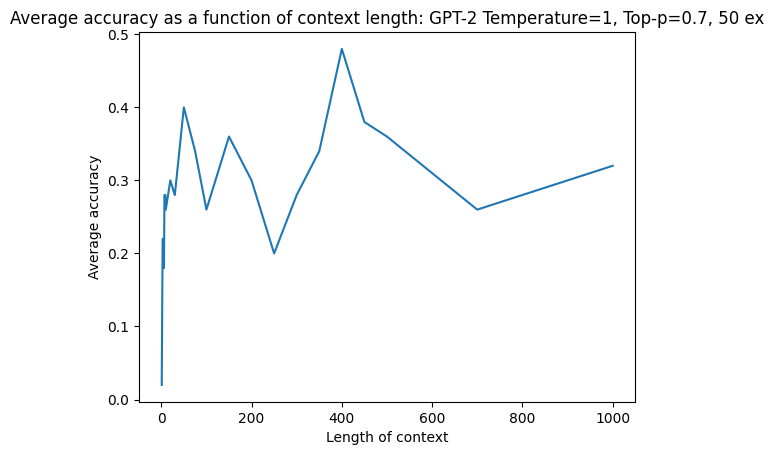

In [27]:
plot_avg_accuracies(output_sampling2_50, "GPT-2 Temperature=1, Top-p=0.7, 50 ex")

### Different model size:

In [ ]:
output_greedy_xl = calculate_accuracies(model=modelgpt2xl, output_filename="accuracies_gpt2xl_greedy_50samples.json",
                                     context_lengths=context_lengths, input_ids=input_ids_xl, attention_mask=attention_mask_xl, num_examples=50, sample=False, temperature=None, top_p=None)

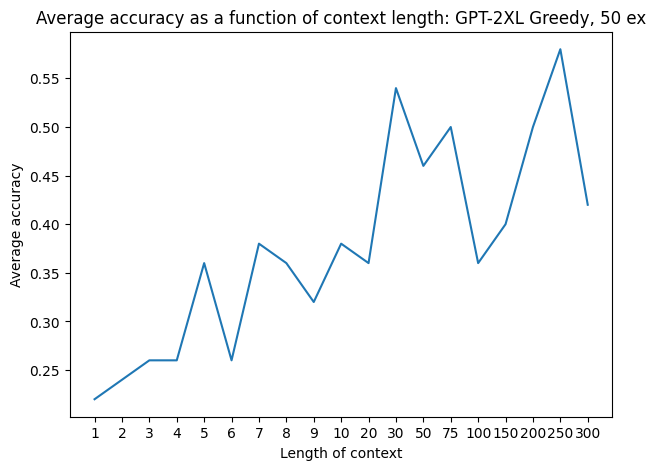

In [48]:
with open("accuracies_gpt2xl_greedy_50samples.json") as f:
  content = f.read()
acc_gpt2xl = json.loads(content)
plot_avg_accuracies(acc_gpt2xl, "GPT-2XL Greedy, 50 ex")

### Comparing models

In [49]:
with open("accuracies_gpt2_greedy_50.json") as f:
  content = f.read()
acc_greedy_50 = json.loads(content)
with open("accuracies_gpt2_temp0-5_topp0-7_50samples.json") as f:
  content = f.read()
acc_sampling_temp0_5 = json.loads(content)
with open("accuracies_gpt2_temp1_topp0-7_50samples.json") as f:
  content = f.read()
acc_sampling_temp1 = json.loads(content)
with open("accuracies_gpt2xl_greedy_50samples.json") as f:
  content = f.read()
acc_greedyxl_50 = json.loads(content)

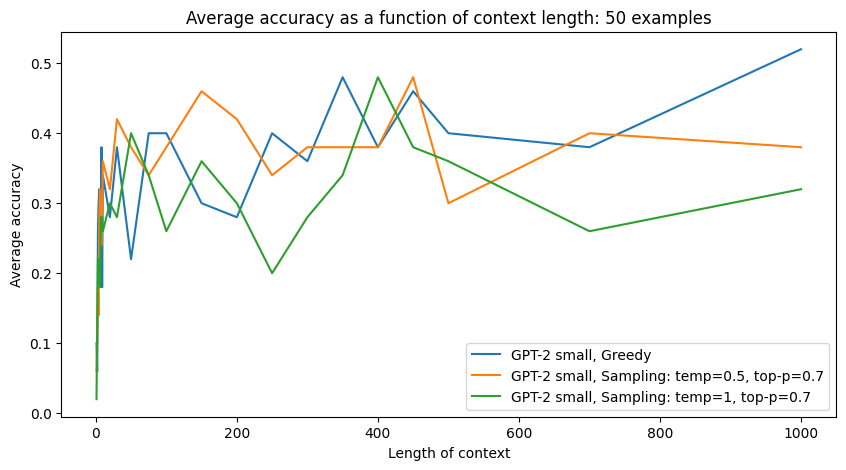

In [78]:
y1 = []
y2 = []
y3 = []
for c in context_lengths:
  line1 = acc_greedy_50[str(c)]
  line2 = acc_sampling_temp0_5[str(c)]
  line3 = acc_sampling_temp1[str(c)]
  inter1, inter2, inter3 = [], [], []
  for t in range(0, 50):
    inter1.append(line1[t][1])
    inter2.append(line2[t][1])
    inter3.append(line3[t][1])
  y1.append(sum(inter1)/len(inter1))
  y2.append(sum(inter2)/len(inter2))
  y3.append(sum(inter3)/len(inter3))

plt.figure(figsize=(10, 5))
plt.plot(context_lengths, y1, label="GPT-2 small, Greedy")
plt.plot(context_lengths, y2, label="GPT-2 small, Sampling: temp=0.5, top-p=0.7")
plt.plot(context_lengths, y3, label="GPT-2 small, Sampling: temp=1, top-p=0.7")
plt.title("Average accuracy as a function of context length: 50 examples")
plt.legend()
plt.xlabel("Length of context")
plt.ylabel("Average accuracy")
plt.show()

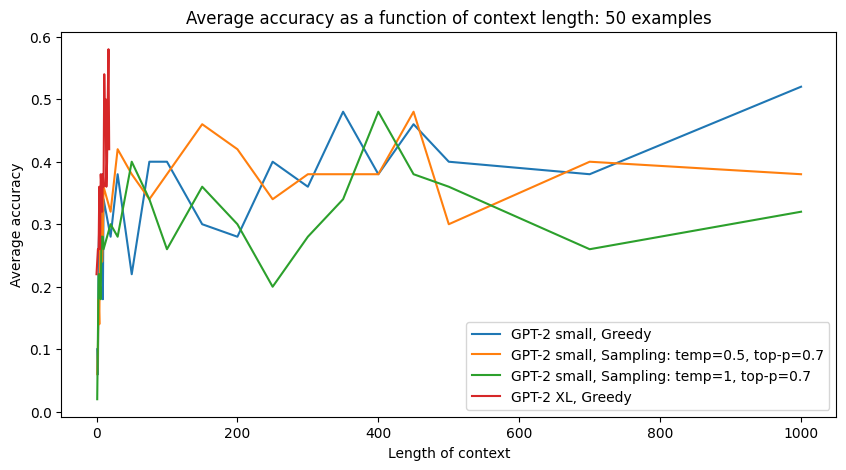

In [65]:
y1 = []
y2 = []
y3 = []
for c in context_lengths:
  line1 = acc_greedy_50[str(c)]
  line2 = acc_sampling_temp0_5[str(c)]
  line3 = acc_sampling_temp1[str(c)]
  inter1, inter2, inter3 = [], [], []
  for t in range(0, 50):
    inter1.append(line1[t][1])
    inter2.append(line2[t][1])
    inter3.append(line3[t][1])
  y1.append(sum(inter1)/len(inter1))
  y2.append(sum(inter2)/len(inter2))
  y3.append(sum(inter3)/len(inter3))
x4=[]
y4=[]
for key,value in acc_greedyxl_50.items():
  x4.append(key)
  inter4=[]
  for t in value:
    inter4.append(t[1])
  y4.append(sum(inter4)/len(inter4))

plt.figure(figsize=(10, 5))
plt.plot(context_lengths, y1, label="GPT-2 small, Greedy")
plt.plot(context_lengths, y2, label="GPT-2 small, Sampling: temp=0.5, top-p=0.7")
plt.plot(context_lengths, y3, label="GPT-2 small, Sampling: temp=1, top-p=0.7")
plt.plot(x4, y4, label="GPT-2 XL, Greedy")
plt.title("Average accuracy as a function of context length: 50 examples")
plt.legend()
plt.xlabel("Length of context")
plt.ylabel("Average accuracy")
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 200, 400, 600, 800, 1000])
plt.show()

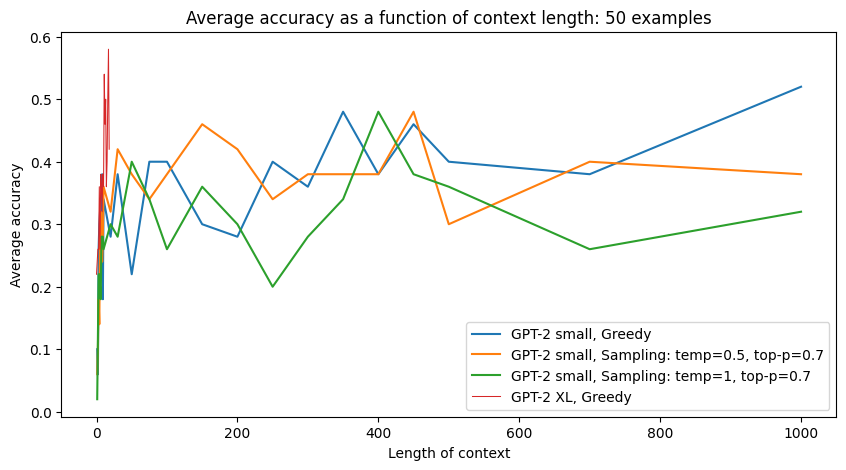

In [74]:
y1 = []
y2 = []
y3 = []
for c in context_lengths:
  line1 = acc_greedy_50[str(c)]
  line2 = acc_sampling_temp0_5[str(c)]
  line3 = acc_sampling_temp1[str(c)]
  inter1, inter2, inter3 = [], [], []
  for t in range(0, 50):
    inter1.append(line1[t][1])
    inter2.append(line2[t][1])
    inter3.append(line3[t][1])
  y1.append(sum(inter1)/len(inter1))
  y2.append(sum(inter2)/len(inter2))
  y3.append(sum(inter3)/len(inter3))
x4=[]
y4=[]
for key,value in acc_greedyxl_50.items():
  x4.append(key)
  inter4=[]
  for t in value:
    inter4.append(t[1])
  y4.append(sum(inter4)/len(inter4))

plt.figure(figsize=(10, 5))
plt.plot(context_lengths, y1, label="GPT-2 small, Greedy")
plt.plot(context_lengths, y2, label="GPT-2 small, Sampling: temp=0.5, top-p=0.7")
plt.plot(context_lengths, y3, label="GPT-2 small, Sampling: temp=1, top-p=0.7")
plt.plot(x4, y4, label="GPT-2 XL, Greedy", linewidth=0.75)
plt.title("Average accuracy as a function of context length: 50 examples")
plt.legend()
plt.xlabel("Length of context")
plt.ylabel("Average accuracy")
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 200, 400, 600, 800, 1000])
plt.show()

# Computing average probabilities of next token

In [69]:
# function to get the average probability of the next correct
# input dataframe of examples
# output dictionary of probabilities per context length
def get_probabilites(df_examples):
  probabilities_per_length = {}
  for ind, row in df_examples.iterrows():
    ex = row["example"]
    encoding = tokenizergpt2(ex, return_tensors="pt")
    encoding_length = len(encoding["input_ids"][0, :])
    for i in range(0, encoding_length - 1):
      context_tokens = encoding["input_ids"][:, 0:i+1]
      context_attention_mask = encoding["attention_mask"][:, 0:i+1]
      with torch.inference_mode():
        output = modelgpt2(input_ids = context_tokens, attention_mask = context_attention_mask)
      correct_next_token = encoding["input_ids"][:, i+1]
      logits = output.logits[0, -1, :]
      probabilities = torch.softmax(logits, -1)
      prob_correct_token = probabilities[correct_next_token]
      if i+1 in probabilities_per_length:
        probabilities_per_length[i+1].append(prob_correct_token)
      else:
        probabilities_per_length[i+1] = [prob_correct_token]
  return probabilities_per_length

In [ ]:
# function to get the probability of the next correct token for one example
# input: one example (string)
# it shows the context and probability for each context length and visualizes
# the probabilities
def see_example(example):
  plt.figure(figsize=(5, 3))
  encoding = tokenizergpt2(example, return_tensors="pt")
  encoding_length = len(encoding["input_ids"][0, :])
  x = np.arange(1, encoding_length)
  y = np.zeros(encoding_length - 1)
  for i in range(0, encoding_length - 1):
    context_tokens = encoding["input_ids"][:, 0:i+1]
    context_attention_mask = encoding["attention_mask"][:, 0:i+1]
    with torch.inference_mode():
      output = modelgpt2(input_ids = context_tokens, attention_mask = context_attention_mask)
    correct_next_token = encoding["input_ids"][:, i+1]
    logits = output.logits[0, -1, :]
    probabilities = torch.softmax(logits, -1)
    prob_correct_token = probabilities[correct_next_token]
    y[i] = prob_correct_token
    print(''.join([tokenizergpt2.decode(token) for token in context_tokens[0, :]]), " | ", prob_correct_token)
    plt.scatter(x, y, s=3, c='blue')
    plt.title("Accuracy as a function of context length")
    plt.xlabel("Length of context")
    plt.ylabel("Probability of the next correct token")

In [70]:
# visualize the average probability trend
# input: output of get_probabilities(data) or get_accuracies
def plot_result(result):
  x = np.zeros(len(result))
  y = np.zeros(len(result))
  t = np.zeros(len(result))
  for i, (key, value) in enumerate(result.items()):
    x[i] = key
    y[i] = (sum(value)/len(value))
    t[i] = len(value)
  plt.scatter(x, y, s=3, c=t)
  plt.title("Accuracy as a function of context length")
  plt.xlabel("Length of context")
  plt.ylabel("Average probability of predicting the correct next token")
  plt.colorbar()

### Individual examples

O  |  tensor([0.0005])
Oat  |  tensor([2.7226e-05])
Oat milk  |  tensor([0.0113])
Oat milk has  |  tensor([0.1467])
Oat milk has a  |  tensor([0.0017])
Oat milk has a creamy  |  tensor([0.4626])
Oat milk has a creamy texture  |  tensor([0.2969])
Oat milk has a creamy texture and  |  tensor([0.0027])
Oat milk has a creamy texture and mild  |  tensor([0.0007])
Oat milk has a creamy texture and mild o  |  tensor([0.0985])
Oat milk has a creamy texture and mild oatmeal  |  tensor([0.0239])
Oat milk has a creamy texture and mild oatmeal-  |  tensor([0.8182])
Oat milk has a creamy texture and mild oatmeal-like  |  tensor([0.3809])
Oat milk has a creamy texture and mild oatmeal-like flavor  |  tensor([0.1134])
Oat milk has a creamy texture and mild oatmeal-like flavor,  |  tensor([0.1335])
Oat milk has a creamy texture and mild oatmeal-like flavor, and  |  tensor([0.1832])
Oat milk has a creamy texture and mild oatmeal-like flavor, and is  |  tensor([0.0001])
Oat milk has a creamy texture and

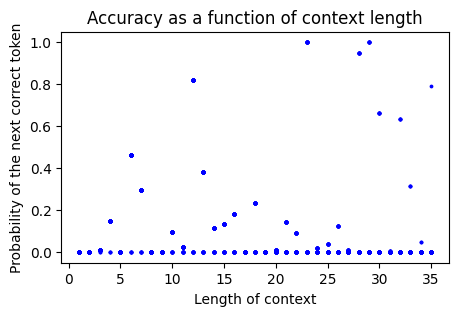

In [ ]:
#https://en.wikipedia.org/wiki/Oat_milk
example = "Oat milk has a creamy texture and mild oatmeal-like flavor, and is manufactured in various flavors, such as sweetened, unsweetened, vanilla, and chocolate."
see_example(example)

As  |  tensor([0.0063])
As an  |  tensor([0.0009])
As an intellectual  |  tensor([0.0036])
As an intellectual object  |  tensor([0.5586])
As an intellectual object,  |  tensor([0.0342])
As an intellectual object, a  |  tensor([0.0156])
As an intellectual object, a book  |  tensor([0.2571])
As an intellectual object, a book is  |  tensor([9.8207e-07])
As an intellectual object, a book is prototyp  |  tensor([0.0514])
As an intellectual object, a book is prototypically  |  tensor([0.3625])
As an intellectual object, a book is prototypically a  |  tensor([0.0010])
As an intellectual object, a book is prototypically a composition  |  tensor([0.3521])
As an intellectual object, a book is prototypically a composition of  |  tensor([0.0008])
As an intellectual object, a book is prototypically a composition of such  |  tensor([0.0009])
As an intellectual object, a book is prototypically a composition of such great  |  tensor([0.0011])
As an intellectual object, a book is prototypically a compo

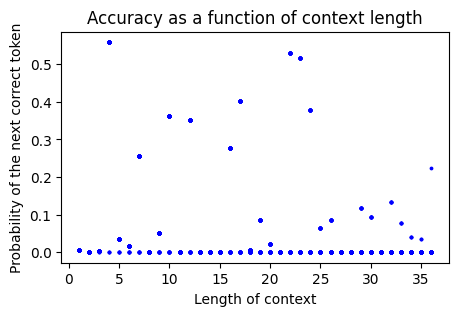

In [ ]:
#https://en.wikipedia.org/wiki/Book
example = "As an intellectual object, a book is prototypically a composition of such great length that it takes a considerable investment of time to compose and still considered as an investment of time to read."
see_example(example)

Photos  |  tensor([1.9360e-06])
Photosynthesis  |  tensor([0.1094])
Photosynthesis is  |  tensor([0.1531])
Photosynthesis is a  |  tensor([0.0027])
Photosynthesis is a biological  |  tensor([0.9639])
Photosynthesis is a biological process  |  tensor([0.0029])
Photosynthesis is a biological process used  |  tensor([0.1032])
Photosynthesis is a biological process used by  |  tensor([0.0648])
Photosynthesis is a biological process used by many  |  tensor([0.0001])
Photosynthesis is a biological process used by many cellular  |  tensor([0.4477])
Photosynthesis is a biological process used by many cellular organisms  |  tensor([0.5368])
Photosynthesis is a biological process used by many cellular organisms to  |  tensor([0.0290])
Photosynthesis is a biological process used by many cellular organisms to convert  |  tensor([0.0142])
Photosynthesis is a biological process used by many cellular organisms to convert light  |  tensor([0.0305])
Photosynthesis is a biological process used by many c

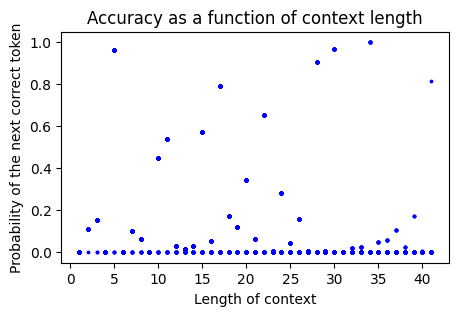

In [ ]:
"https://en.wikipedia.org/wiki/Photosynthesis"
example = "Photosynthesis is a biological process used by many cellular organisms to convert light energy into chemical energy, which is stored in organic compounds that can later be metabolized through cellular respiration to fuel the organism's activities."
see_example(example)

### Average over multiple examples

In [68]:
data = pd.read_csv("test_data.csv")
data

,example,link
0,Photosynthesis is a biological process used by...,https://en.wikipedia.org/wiki/Photosynthesis
1,Oat milk is a plant milk derived from whole oa...,https://en.wikipedia.org/wiki/Oat_milk
2,Plants are the eukaryotes that form the kingdo...,https://en.wikipedia.org/wiki/Plant
3,The food system has significant impacts on a w...,https://en.wikipedia.org/wiki/Food
4,"Grain, fruit, and vegetables are basic human f...",https://en.wikipedia.org/wiki/Plant
5,"A developed country, Canada has one of the hig...",https://en.wikipedia.org/wiki/Canada
6,Caterpillars of most species eat plant materia...,https://en.wikipedia.org/wiki/Caterpillar
7,"Human food can be classified in various ways, ...",https://en.wikipedia.org/wiki/Food
8,The appearance of a caterpillar can often repe...,https://en.wikipedia.org/wiki/Caterpillar
9,The use of oil lamps began thousands of years ...,https://en.wikipedia.org/wiki/Oil_lamp


In [71]:
result = get_probabilites(data)

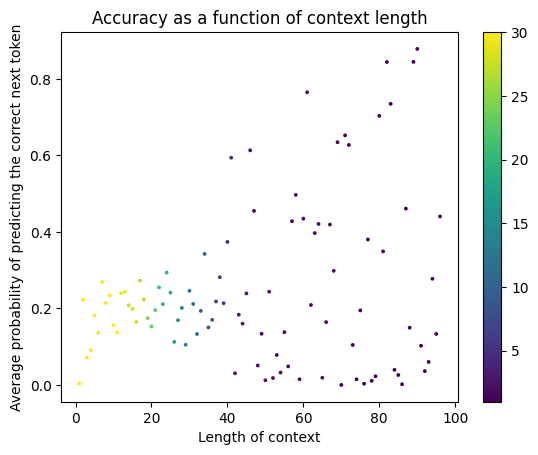

In [72]:
# colour bar shows how many examples had that context length
plot_result(result)